# Load Data

### Small Test Example
* Load one sample each of interictal and preictal and split each into 10s windows.

In [1]:
def get_data_key_from_filename(filename):
    filename = filename.split("/")
    filename = filename[-1].split(".")
    filename = filename[0].split("_")
    filename = filename[2:]
    filename[-1] = filename[-1].lstrip("0")
    return "_".join(filename)

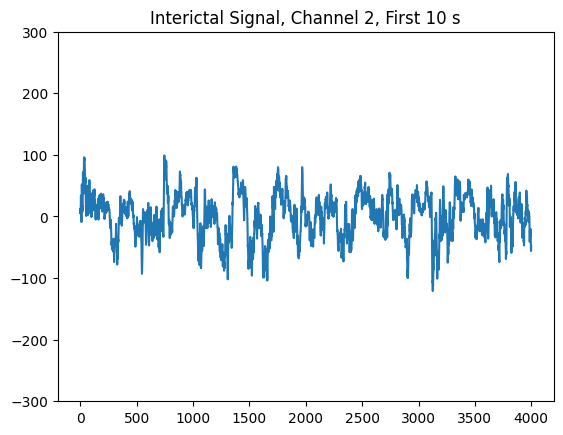

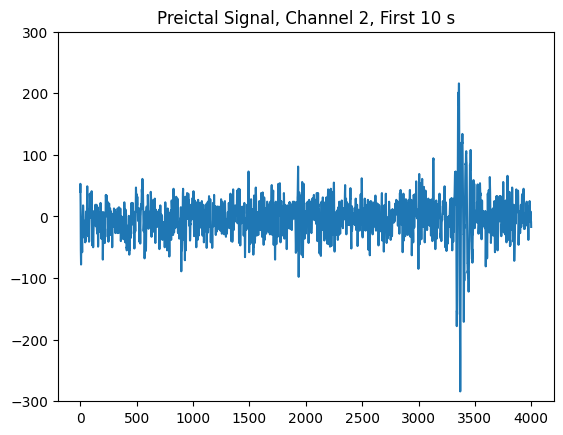

In [2]:
import matplotlib.pyplot as plt
# from feature_extraction import get_data_key_from_filename
import os
from scipy.io import loadmat
import numpy as np

root_folder = ""  #/Volumes/LACIE SHARE/seizure-prediction"
train_interictal_file = "Dog_1_interictal_segment_0009.mat"  #"Dog_1/Dog_1/Dog_1_interictal_segment_0009.mat"
train_preictal_file = "Dog_1_preictal_segment_0013.mat"  #"Dog_1/Dog_1/Dog_1_preictal_segment_0013.mat"

filepath = os.path.join(root_folder, train_interictal_file)
mat_data = loadmat(filepath)
signals_interictal = np.array(mat_data[get_data_key_from_filename(train_interictal_file)][0, 0][0])
signals_interictal = np.transpose(signals_interictal)   # convert so # timepoints x # channels
filepath = os.path.join(root_folder, train_preictal_file)
mat_data = loadmat(filepath)
signals_preictal = np.array(mat_data[get_data_key_from_filename(train_preictal_file)][0, 0][0])
signals_preictal = np.transpose(signals_preictal)   # convert so # timepoints x # channels

plt.plot(signals_interictal[0:4000, 1])
plt.title("Interictal Signal, Channel 2, First 10 s")
plt.ylim(-300, 300)
plt.show()
plt.plot(signals_preictal[0:4000, 1])
plt.title("Preictal Signal, Channel 2, First 10 s")
plt.ylim(-300, 300)
plt.show()

239766
3766
(236000, 16)
(236000, 16)
Interictal Tensor Shape: (59, 4000, 16)
Preictal Tensor Shape: (59, 4000, 16)


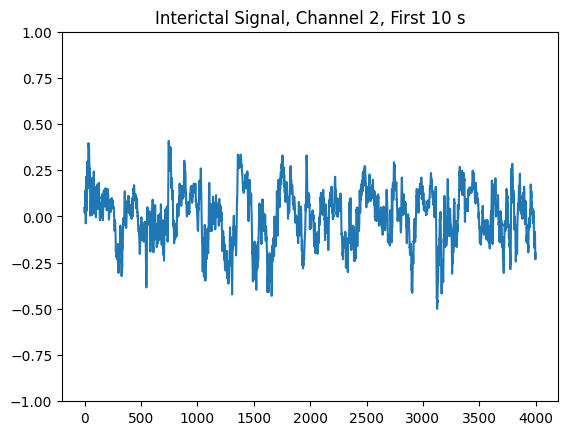

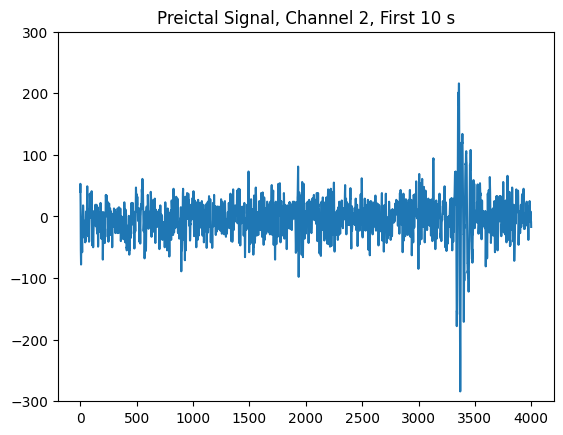

X shape: (59, 4000, 16)


In [3]:
# create tensors
import tensorflow as tf
import torch
from sklearn.preprocessing import MaxAbsScaler

WINDOW_SIZE = 4000  # sample count, approximately 10 s
NUM_CHANNELS = 16

extra_rows_interictal = signals_interictal.shape[0] % WINDOW_SIZE
print(signals_interictal.shape[0])
print(extra_rows_interictal)
# exclude last segment if < WINDOW_SIZE
if extra_rows_interictal > 0:
    signals_interictal = signals_interictal[:-extra_rows_interictal, :]
print(signals_interictal.shape)

extra_rows_preictal = signals_preictal.shape[0] % WINDOW_SIZE
# exclude last segment if < WINDOW_SIZE
if extra_rows_preictal > 0:
    signals_preictal = signals_preictal[:-extra_rows_preictal, :]
print(signals_preictal.shape)

max_abs_scaler = MaxAbsScaler()
signals_interictal = max_abs_scaler.fit_transform(signals_interictal)

windowed_interictal = signals_interictal.reshape(-1, WINDOW_SIZE, NUM_CHANNELS)
windowed_preictal = signals_preictal.reshape(-1, WINDOW_SIZE, NUM_CHANNELS)

print(f"Interictal Tensor Shape: {windowed_interictal.shape}")
print(f"Preictal Tensor Shape: {windowed_preictal.shape}")

plt.plot(windowed_interictal[0, :, 1])
plt.title("Interictal Signal, Channel 2, First 10 s")
plt.ylim(-1, 1)
plt.show()
plt.plot(windowed_preictal[0, :, 1])
plt.title("Preictal Signal, Channel 2, First 10 s")
plt.ylim(-300, 300)
plt.show()

# X = np.concatenate( (windowed_interictal, windowed_preictal) )
X = windowed_interictal

# y = np.concatenate( (np.zeros(windowed_interictal.shape[0],), np.ones(windowed_preictal.shape[0],)) )
print(f"X shape: {X.shape}")
# print(f"y shape: {y.shape}")

# Define WGAN

In [11]:
from tensorflow.keras import layers, backend, constraints
import time
from IPython import display

WINDOW_SIZE = 4000  # sample count, approximately 10 s
NUM_CHANNELS = 16
BATCH_SIZE = 16
NOISE_DIM = 100
# N_CRITIC = 1  # number of times to update critic for every time generator is trained

# seed for visualizing progress
num_examples_to_generate = 1
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

def discriminator_wasserstein_loss(real_output, fake_output):
    return backend.mean(tf.concat([-1*tf.ones_like(real_output) * real_output,
                                   tf.ones_like(fake_output) * fake_output], 0))

def generator_wasserstein_loss(fake_output):
    return backend.mean(-1*tf.ones_like(fake_output) * fake_output)

# ClipConstraint class copied from
# https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/
# clip model weights to a given hypercube
class ClipConstraint(constraints.Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}


disc_constraint = ClipConstraint(0.01)


def generate_and_save_signals(model, epoch, test_input, savefig=False):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(12, 12))

    for i in range(NUM_CHANNELS):
        plt.subplot(4, 4, i+1)
        plt.plot(predictions[0, 0:400, i, 0])
        plt.title(f"Channel {i+1}")

    if savefig:
        plt.savefig('./signals_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


class WGAN():
    def __init__(self, n_critic=1, learning_rate=0.00005):
        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()

        self.generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        self.discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        self.checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)
        self.n_critic = n_critic

    def make_generator_model(self):
        """Adapted from code here: https://www.tensorflow.org/tutorials/generative/dcgan
        """
        model = tf.keras.Sequential()
        model.add(layers.Dense(int(WINDOW_SIZE/4)*256, use_bias=False, input_shape=(NOISE_DIM,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Reshape((int(WINDOW_SIZE/4), 256)))
        assert model.output_shape == (None, WINDOW_SIZE/4, 256)  # Note: None is the batch size

        model.add(layers.Conv1DTranspose(128, 5, strides=1, padding='same', use_bias=False))
        assert model.output_shape == (None, int(WINDOW_SIZE/4), 128)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv1DTranspose(64, 5, strides=2, padding='same', use_bias=False))
        assert model.output_shape == (None, int(WINDOW_SIZE/2), 64)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv1DTranspose(NUM_CHANNELS, 5, strides=2, padding='same', use_bias=False, activation='tanh'))
        model.add(layers.Reshape((WINDOW_SIZE, NUM_CHANNELS, 1)))
        assert model.output_shape == (None, WINDOW_SIZE, NUM_CHANNELS, 1)

        return model

    def make_discriminator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(128, (5, NUM_CHANNELS), strides=(2, 1), padding='valid',
                                         input_shape=[WINDOW_SIZE, NUM_CHANNELS, 1],
                                kernel_constraint = disc_constraint))
        # print(model.output_shape)
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(256, (5, 1), strides=(2, 1), padding='valid',
                                kernel_constraint = disc_constraint))
        # print(model.output_shape)
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model

    # Notice the use of `tf.function`
    # This annotation causes the function to be "compiled".
    @tf.function
    def train_step(self, signals):
        """Mostly copied from https://www.tensorflow.org/tutorials/generative/dcgan
        """
        for _ in range(self.n_critic):
            noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

            with tf.GradientTape() as disc_tape:
                generated_signals = self.generator(noise, training=False)

                real_output = self.discriminator(signals, training=True)
                fake_output = self.discriminator(generated_signals, training=True)

                disc_loss = discriminator_wasserstein_loss(real_output, fake_output)
                real_score = backend.mean(real_output)
                fake_score = backend.mean(fake_output)

            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        with tf.GradientTape() as gen_tape:
            generated_signals = self.generator(noise, training=True)

            fake_output = self.discriminator(generated_signals, training=False)

            gen_loss = generator_wasserstein_loss(fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        return gen_loss, disc_loss, real_score, fake_score

    def train(self, dataset, epochs):
        gen_losses = []
        disc_losses = []
        real_scores = []
        fake_scores = []
        for epoch in range(epochs):
            start = time.time()

            running_gen_loss = []
            running_disc_loss = []
            running_real_score = []
            running_fake_score = []
            for batch in dataset:
                # print("Running training step")
                gen_loss, disc_loss, real_score, fake_score = self.train_step(batch)
                running_gen_loss.append(gen_loss)
                running_disc_loss.append(disc_loss)
                running_real_score.append(real_score)
                running_fake_score.append(fake_score)

            gen_losses.append(np.mean(running_gen_loss))
            disc_losses.append(np.mean(running_disc_loss))
            real_scores.append(np.mean(running_real_score))
            fake_scores.append(np.mean(running_fake_score))

            # Produce images for the GIF as you go
            display.clear_output(wait=True)
            generate_and_save_signals(self.generator,
                                     epoch + 1,
                                     seed)

            plt.plot(gen_losses, label='Generator Loss')
            plt.plot(disc_losses, label='Discriminator Loss')
            plt.legend()
            plt.show()

            plt.plot(real_scores, label='Real Score')
            plt.plot(fake_scores, label='Fake Score')
            plt.legend()
            plt.show()

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
              self.checkpoint.save(file_prefix = self.checkpoint_prefix)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_signals(self.generator,
                               epochs,
                               seed, savefig=True)

        results = {'gen_losses': gen_losses, 'disc_losses': disc_losses,
                   'real_scores': real_scores, 'fake_scores': fake_scores}
        return results


wgan = WGAN()
noise = tf.random.normal([1, 100])
generated_signal = wgan.generator(noise, training=False)
print(generated_signal.shape)
decision = wgan.discriminator(generated_signal)
print(decision)

(1, 4000, 16, 1)
tf.Tensor([[-0.00034476]], shape=(1, 1), dtype=float32)


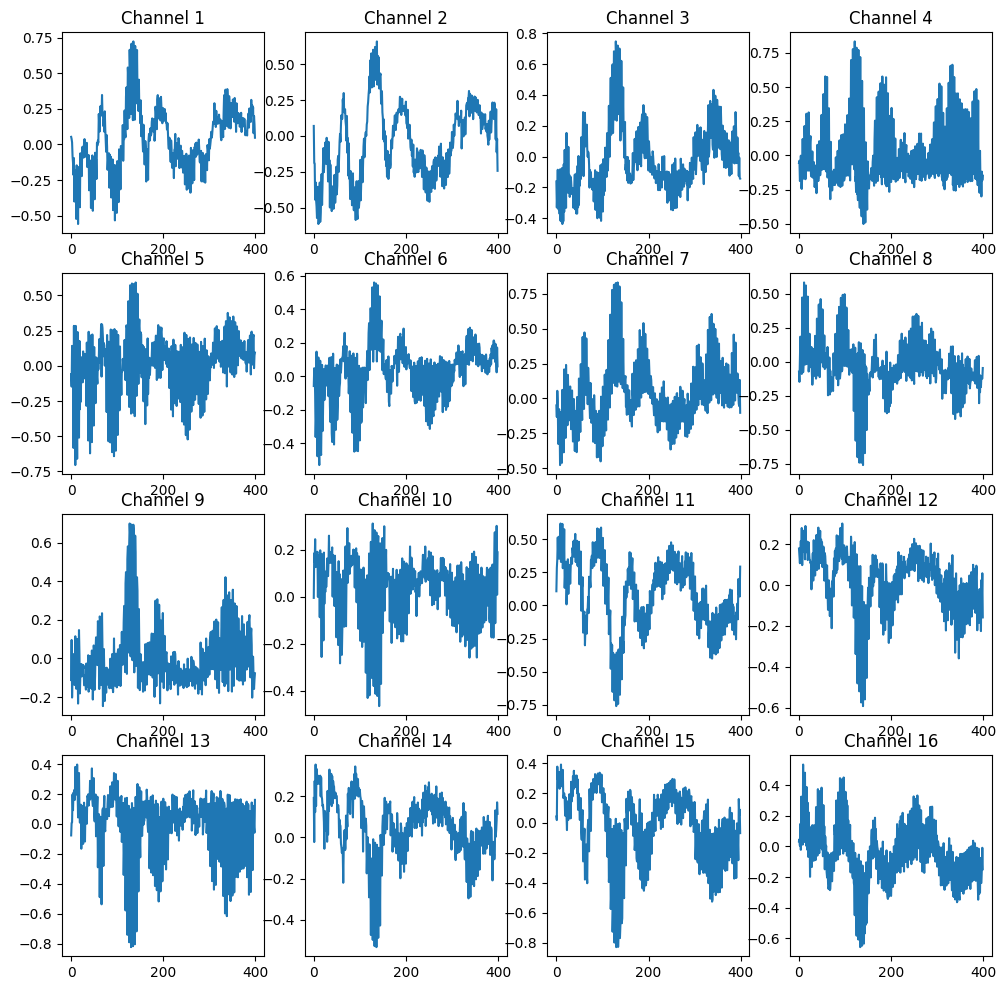

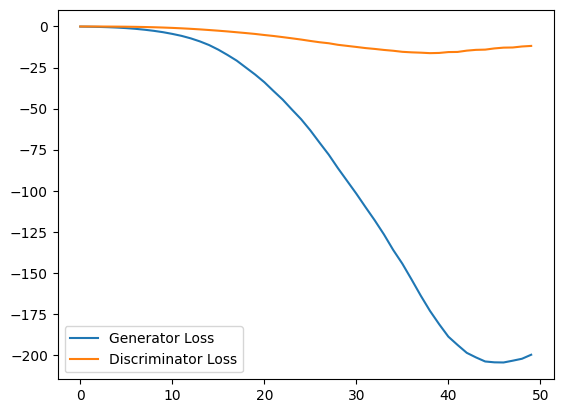

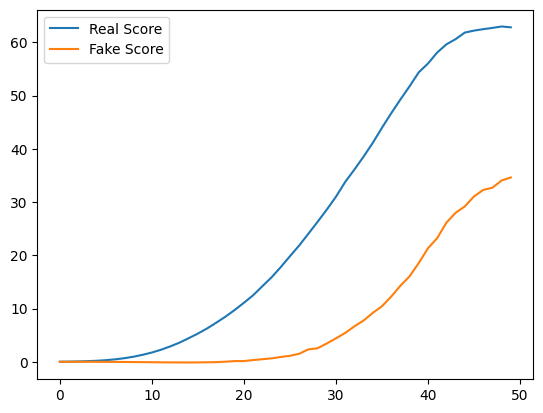

In [10]:
import pickle

EPOCHS = 50
BUFFER_SIZE = 10000

train_dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
results = wgan.train(train_dataset, EPOCHS)

with open("training_results", 'wb') as f:
    pickle.dump(results, f )

plt.plot(results['gen_losses'], label='Generator Loss')
plt.plot(results['disc_losses'], label='Discriminator Loss')
plt.legend()
plt.show()

plt.plot(results['real_scores'], label='Real Score')
plt.plot(results['fake_scores'], label='Fake Score')
plt.legend()
plt.show()

In [16]:
# test wasserstein loss
real_output = tf.convert_to_tensor([0, 0.3, -0.7, 0.5, 1, -1])
fake_output = tf.convert_to_tensor([-1, -1, -0.4, 0.2, 0.7, 0.9])

print(generator_wasserstein_loss(fake_output))  # should be about 0.1
print(discriminator_wasserstein_loss(real_output, fake_output))  # should be about -0.0583

tf.Tensor(0.100000024, shape=(), dtype=float32)
tf.Tensor(-0.058333337, shape=(), dtype=float32)
